In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm

In [3]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

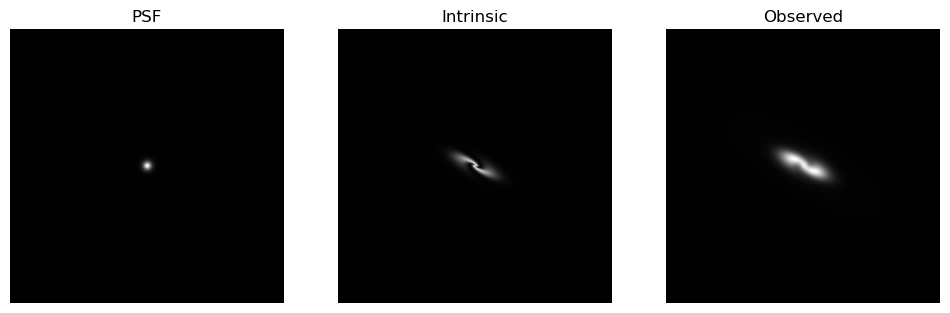

In [4]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [15]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252183
The aperture flux using the observed image and rescaled weight function : 0.252183


/home/deklerk/GAAP/src/analysis.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))


/home/deklerk/GAAP/src/analysis.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))


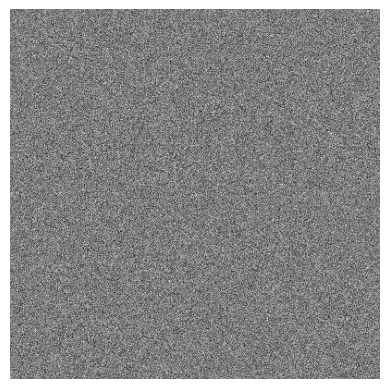

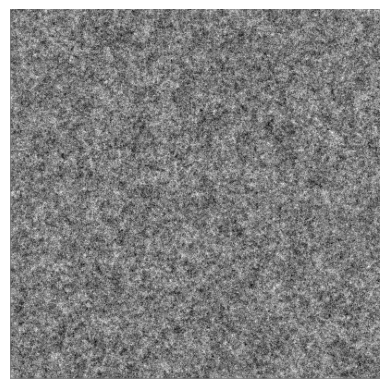

  0%|          | 0/100 [00:00<?, ?it/s]/var/tmp/deklerk/ipykernel_1834532/3123313192.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  measured_fluxes[i]  = measured_F
100%|██████████| 100/100 [00:05<00:00, 19.65it/s]


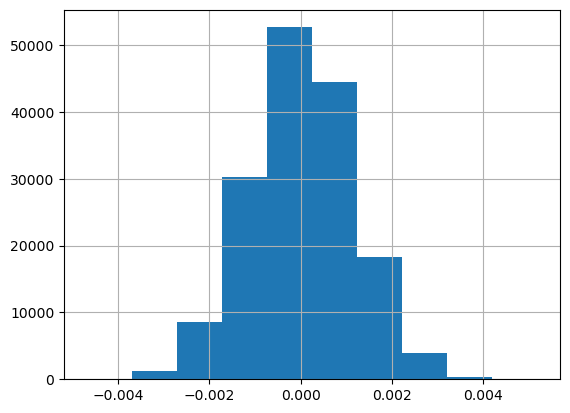

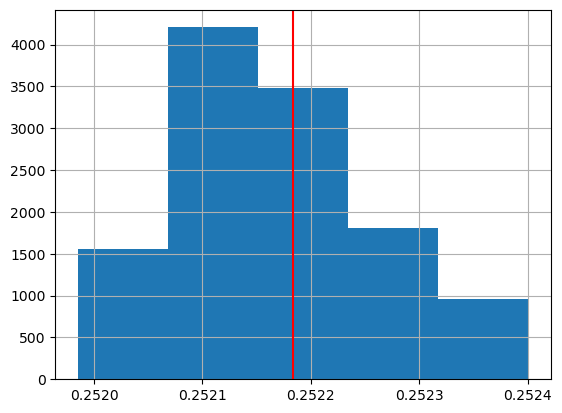

0.25218326 0.01
0.25217138886451723 9.09673419342905e-05 1.6578210525448812e-05


In [37]:
N = 100
measured_fluxes = np.zeros(N)
measured_sigmas = np.zeros(N)
true_F, _ = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
true_sigma = 0.01
noise_psf = moffat(width, height, 1, 0.5)
noise = np.random.normal(0, true_sigma, (width, height))
plt.imshow(noise)
plt.show()
noise = fftconvolve(noise, noise_psf, mode='same')
plt.imshow(noise)
plt.show()
for i in tqdm(range(N)):
    noise = np.random.normal(0, true_sigma, (width, height))
    noise = fftconvolve(noise, noise_psf, mode='same')
    measured_F, sigma_F = calculate_gaap_flux(image+noise, image_psf, weight, [(height / 2, width / 2)])
    measured_fluxes[i]  = measured_F
    measured_sigmas[i] = sigma_F
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.hist(noise.flatten())
    plt.show()
    # plt.fill_between(np.linspace(true_F-sigma_F, true_F+sigma_F, 100), 0, 3000, color='red', alpha=0.2)
    plt.axvline(true_F, c='r')
    plt.hist(measured_fluxes, bins=N//20, density=True)
    plt.show()

print(true_F[0], true_sigma)
print(np.mean(measured_fluxes), np.std(measured_fluxes), np.mean(measured_sigmas))
# plt.hist(measured_fluxes)